<a href="https://colab.research.google.com/github/dstephenhaynes/DTSA5510/blob/main/DTSA5510_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


In [11]:
# Define the URL of the file
url = 'https://raw.githubusercontent.com/dstephenhaynes/DTSA5510/main/movie_titles_metadata.txt'

# Fetch the file content from the URL
response = requests.get(url)
data = response.text

# Define the column names based on the data description
columns = ['movie_id', 'movie_title', 'movie_year', 'imdb_rating', 'imdb_id', 'genres']

# Initialize an empty list to hold the rows of the DataFrame
rows = []

# Read the data and parse each line
for line in data.splitlines():
    # Split the line by the delimiter
    fields = line.strip().split(' +++$+++ ')
    # Parse the genres field from string representation of list to actual list
    fields[-1] = eval(fields[-1])
    # Append the parsed fields to the rows list
    rows.append(fields)

# Create the DataFrame
movies = pd.DataFrame(rows, columns=columns)

# Display the first few rows of the DataFrame
print(movies.head())

# Optional: Save the DataFrame to a CSV file for easier inspection and reuse
movies.to_csv('movie_titles_metadata.csv', index=False)


  movie_id                 movie_title movie_year imdb_rating imdb_id  \
0       m0  10 things i hate about you       1999        6.90   62847   
1       m1  1492: conquest of paradise       1992        6.20   10421   
2       m2                  15 minutes       2001        6.10   25854   
3       m3       2001: a space odyssey       1968        8.40  163227   
4       m4                     48 hrs.       1982        6.90   22289   

                                     genres  
0                         [comedy, romance]  
1    [adventure, biography, drama, history]  
2          [action, crime, drama, thriller]  
3              [adventure, mystery, sci-fi]  
4  [action, comedy, crime, drama, thriller]  


In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     617 non-null    object
 1   movie_title  617 non-null    object
 2   movie_year   617 non-null    object
 3   imdb_rating  617 non-null    object
 4   imdb_id      617 non-null    object
 5   genres       617 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


In [13]:
# Define the URLs of the files
urls = [
    'https://raw.githubusercontent.com/dstephenhaynes/DTSA5510/main/movie_lines_1.txt',
    'https://raw.githubusercontent.com/dstephenhaynes/DTSA5510/main/movie_lines_2.txt'
]

# Initialize an empty list to hold the rows of the DataFrame
rows = []

# Define the column names based on the data description
columns = ['line_id', 'character_id', 'movie_id', 'character_name', 'dialogue']

# Fetch and process each file
for url in urls:
    response = requests.get(url)
    data = response.text

    # Read the data and parse each line
    for line in data.splitlines():
        # Split the line by the delimiter
        fields = line.strip().split(' +++$+++ ')
        # Append the parsed fields to the rows list
        rows.append(fields)

# Create the DataFrame
dialogue = pd.DataFrame(rows, columns=columns)

# Display the first few rows of the DataFrame
print(dialogue.head())

# Optional: Save the DataFrame to a CSV file for easier inspection and reuse
dialogue.to_csv('movie_lines.csv', index=False)


  line_id character_id movie_id character_name      dialogue
0   L1045           u0       m0         BIANCA  They do not!
1   L1044           u2       m0        CAMERON   They do to!
2    L985           u0       m0         BIANCA    I hope so.
3    L984           u2       m0        CAMERON     She okay?
4    L925           u0       m0         BIANCA     Let's go.


In [15]:
dialogue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   line_id         304713 non-null  object
 1   character_id    304713 non-null  object
 2   movie_id        304713 non-null  object
 3   character_name  304713 non-null  object
 4   dialogue        304446 non-null  object
dtypes: object(5)
memory usage: 11.6+ MB


In [17]:
# prompt: print entries from dialogue dataframe that are null

print(dialogue.isnull().sum())


line_id             0
character_id        0
movie_id            0
character_name      0
dialogue          267
dtype: int64


In [21]:

# Convert columns to appropriate data types
movies['movie_year'] = pd.to_numeric(movies['movie_year'], errors='coerce')
movies['imdb_rating'] = pd.to_numeric(movies['imdb_rating'], errors='coerce')
movies['imdb_id'] = pd.to_numeric(movies['imdb_id'], errors='coerce')

# Convert genres column to list if it's a string
movies['genres'] = movies['genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Handle missing values in dialogue
dialogue['dialogue'] = dialogue['dialogue'].fillna('')  # Replace NaN dialogues with empty strings

# Display cleaned data information
print(movies.info())
print(dialogue.info())

# Display the first few rows of the cleaned DataFrames
print(movies.head())
print(dialogue.head())

# Optional: Save the cleaned DataFrames to CSV files for easier inspection and reuse
movies.to_csv('cleaned_movie_titles_metadata.csv', index=False)
dialogue.to_csv('cleaned_movie_lines.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie_id     617 non-null    object 
 1   movie_title  617 non-null    object 
 2   movie_year   601 non-null    float64
 3   imdb_rating  617 non-null    float64
 4   imdb_id      617 non-null    int64  
 5   genres       617 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 29.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   line_id         304713 non-null  object
 1   character_id    304713 non-null  object
 2   movie_id        304713 non-null  object
 3   character_name  304713 non-null  object
 4   dialogue        304713 non-null  object
dtypes: object(5)
memory usage: 11.6+ MB
None
  movie_id           

       movie_id                 movie_title   movie_year  imdb_rating  \
count       617                         617   601.000000   617.000000   
unique      617                         617          NaN          NaN   
top          m0  10 things i hate about you          NaN          NaN   
freq          1                           1          NaN          NaN   
mean        NaN                         NaN  1988.347754     6.863857   
std         NaN                         NaN    16.678845     1.215233   
min         NaN                         NaN  1927.000000     2.500000   
25%         NaN                         NaN  1984.000000     6.200000   
50%         NaN                         NaN  1994.000000     7.000000   
75%         NaN                         NaN  1999.000000     7.800000   
max         NaN                         NaN  2010.000000     9.300000   

              imdb_id   genres  
count      617.000000      617  
unique            NaN      290  
top               NaN  [

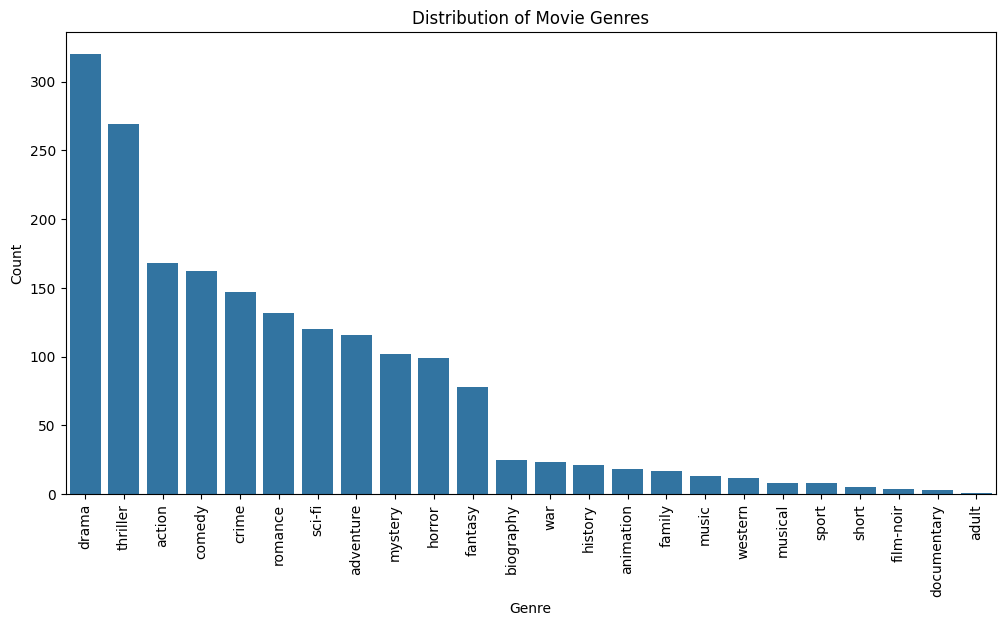

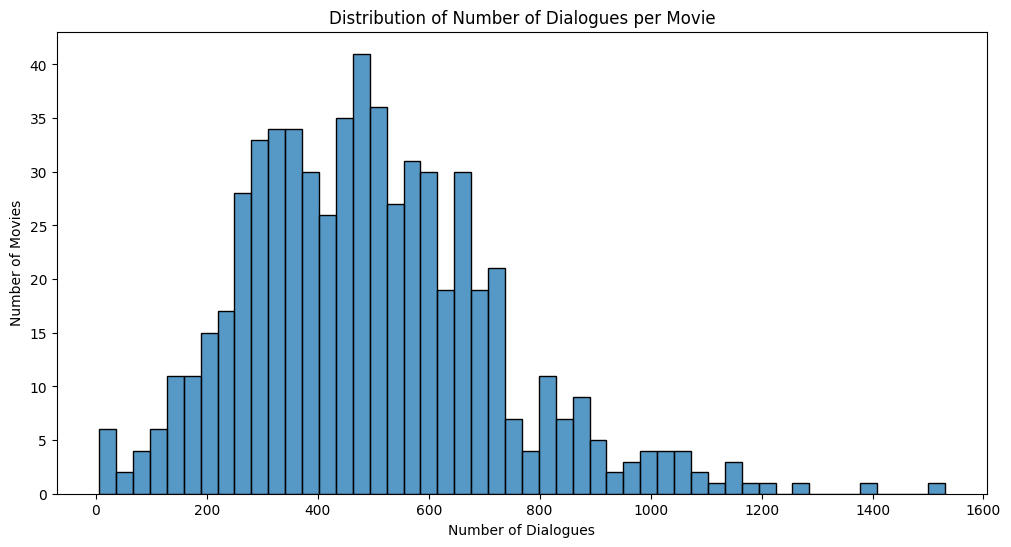

In [23]:

# Summary statistics
print(movies.describe(include='all'))
print(dialogue.describe(include='all'))

# Distribution of genres
all_genres = [genre for sublist in movies['genres'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Number of dialogues per movie
dialogues_per_movie = dialogue['movie_id'].value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(dialogues_per_movie, bins=50)
plt.title('Distribution of Number of Dialogues per Movie')
plt.xlabel('Number of Dialogues')
plt.ylabel('Number of Movies')
plt.show()

In [25]:
# Combine dialogues for each movie
dialogue_combined = dialogue.groupby('movie_id')['dialogue'].apply(lambda x: ' '.join(x)).reset_index()

# Merge with movie metadata
movie_dialogues = movies.merge(dialogue_combined, on='movie_id', how='left')

# Text preprocessing and TF-IDF feature extraction
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(movie_dialogues['dialogue'].fillna(''))

# Perform PCA for dimensionality reduction (optional)
pca = PCA(n_components=50)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

# Add PCA components to DataFrame
for i in range(tfidf_pca.shape[1]):
    movie_dialogues[f'pca_component_{i+1}'] = tfidf_pca[:, i]

print(movie_dialogues.head())


  movie_id                 movie_title  movie_year  imdb_rating  imdb_id  \
0       m0  10 things i hate about you      1999.0          6.9    62847   
1       m1  1492: conquest of paradise      1992.0          6.2    10421   
2       m2                  15 minutes      2001.0          6.1    25854   
3       m3       2001: a space odyssey      1968.0          8.4   163227   
4       m4                     48 hrs.      1982.0          6.9    22289   

                                     genres  \
0                         [comedy, romance]   
1    [adventure, biography, drama, history]   
2          [action, crime, drama, thriller]   
3              [adventure, mystery, sci-fi]   
4  [action, comedy, crime, drama, thriller]   

                                            dialogue  pca_component_1  \
0  They do not! They do to! I hope so. She okay? ...        -0.206674   
1  Can't be that far, I say.  Also, I don't like ...         0.213208   
2  Officers, there's your killer, do your

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.04293107080124663


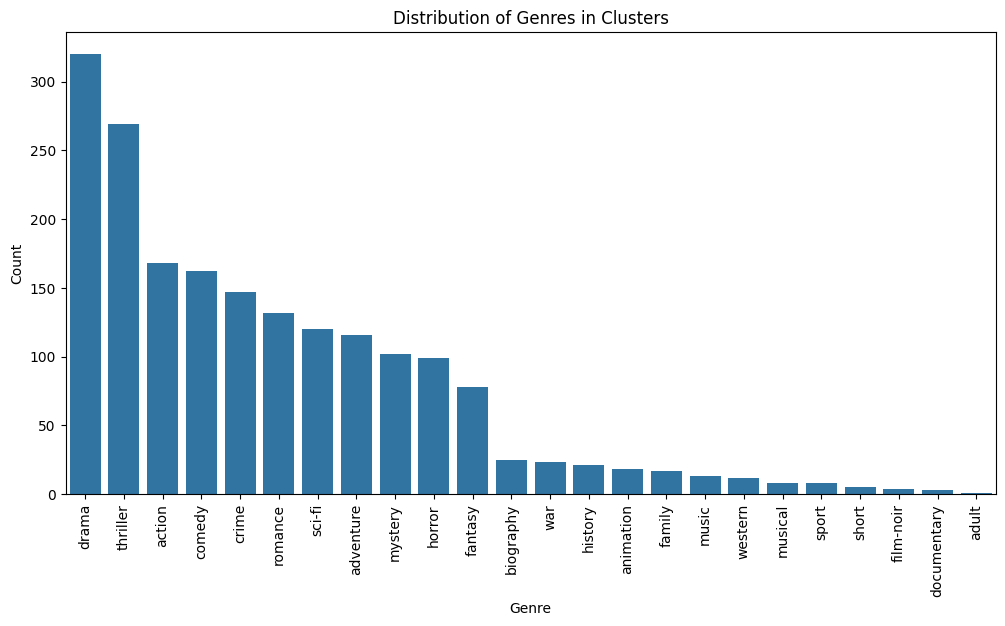

In [27]:
# Select features for clustering
features = [f'pca_component_{i+1}' for i in range(tfidf_pca.shape[1])]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
movie_dialogues['cluster'] = kmeans.fit_predict(movie_dialogues[features])

# Evaluate clustering
silhouette_avg = silhouette_score(movie_dialogues[features], movie_dialogues['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# Analyze clustering results
cluster_genres = movie_dialogues.groupby('cluster')['genres'].apply(lambda x: [genre for sublist in x for genre in sublist])
cluster_genre_counts = cluster_genres.apply(pd.Series).stack().reset_index(level=1, drop=True).value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_genre_counts.index, y=cluster_genre_counts.values)
plt.title('Distribution of Genres in Clusters')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [28]:
# Add the cluster labels to the movie_dialogues DataFrame
movie_dialogues['cluster'] = kmeans.labels_

# Explore the genres within each cluster
for cluster in sorted(movie_dialogues['cluster'].unique()):
    print(f"Cluster {cluster}:")
    print(movie_dialogues[movie_dialogues['cluster'] == cluster]['genres'].value_counts())
    print("\n")

# Example of displaying some movies in a cluster
for cluster in sorted(movie_dialogues['cluster'].unique()):
    print(f"Cluster {cluster} Example Movies:")
    print(movie_dialogues[movie_dialogues['cluster'] == cluster][['movie_title', 'genres']].head())
    print("\n")


Cluster 0:
genres
[drama]                                         5
[comedy, romance]                               3
[comedy, drama, romance]                        3
[action, adventure, thriller]                   2
[drama, romance]                                2
[horror]                                        2
[drama, horror, thriller]                       2
[action, drama, thriller]                       1
[drama, horror, mystery, thriller, thriller]    1
[comedy, drama, fantasy]                        1
[comedy, crime, mystery]                        1
[biography, drama]                              1
[crime, drama, fantasy, thriller]               1
[drama, fantasy, romance]                       1
[biography, drama, history, romance]            1
[drama, mystery, romance, thriller]             1
[horror, mystery, thriller]                     1
[comedy, crime, music]                          1
[drama, mystery]                                1
[crime, drama, romance, thriller

In [30]:

# Prepare dialogues for Word2Vec
dialogue_sentences = [dialogue.split() for dialogue in movie_dialogues['dialogue'].fillna('')]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=dialogue_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Get Word2Vec features
def get_w2v_features(sentence, model, num_features):
    words = sentence.split()
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

w2v_features = np.array([get_w2v_features(dialogue, w2v_model, 100) for dialogue in movie_dialogues['dialogue'].fillna('')])

# Standardize the features
scaler = StandardScaler()
w2v_features_scaled = scaler.fit_transform(w2v_features)

# Apply PCA
pca = PCA(n_components=50)
w2v_pca = pca.fit_transform(w2v_features_scaled)

# Add PCA components to DataFrame
for i in range(w2v_pca.shape[1]):
    movie_dialogues[f'w2v_pca_component_{i+1}'] = w2v_pca[:, i]

print(movie_dialogues.head())


  movie_id                 movie_title  movie_year  imdb_rating  imdb_id  \
0       m0  10 things i hate about you      1999.0          6.9    62847   
1       m1  1492: conquest of paradise      1992.0          6.2    10421   
2       m2                  15 minutes      2001.0          6.1    25854   
3       m3       2001: a space odyssey      1968.0          8.4   163227   
4       m4                     48 hrs.      1982.0          6.9    22289   

                                     genres  \
0                         [comedy, romance]   
1    [adventure, biography, drama, history]   
2          [action, crime, drama, thriller]   
3              [adventure, mystery, sci-fi]   
4  [action, comedy, crime, drama, thriller]   

                                            dialogue  pca_component_1  \
0  They do not! They do to! I hope so. She okay? ...        -0.206674   
1  Can't be that far, I say.  Also, I don't like ...         0.213208   
2  Officers, there's your killer, do your

<ipython-input-30-c7a5c57f8720>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movie_dialogues[f'w2v_pca_component_{i+1}'] = w2v_pca[:, i]
<ipython-input-30-c7a5c57f8720>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movie_dialogues[f'w2v_pca_component_{i+1}'] = w2v_pca[:, i]
<ipython-input-30-c7a5c57f8720>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from itertools import product

# Define a range of parameters to iterate through
eps_values = [0.1, 0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15]

best_score = -1
best_params = {}

# Iterate through all combinations of parameters
for eps, min_samples in product(eps_values, min_samples_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_clusters = dbscan.fit_predict(filtered_data[features])

    # Only calculate silhouette score if there is more than one cluster
    if len(set(dbscan_clusters)) > 1:
        silhouette_avg = silhouette_score(filtered_data[features], dbscan_clusters)
        print(f'Silhouette Score for eps={eps}, min_samples={min_samples}: {silhouette_avg}')

        # Update best score and parameters if needed
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = {'eps': eps, 'min_samples': min_samples}

print(f'Best Silhouette Score: {best_score} with parameters: {best_params}')


ValueError: Found array with 0 sample(s) (shape=(0, 50)) while a minimum of 1 is required by DBSCAN.